In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd

import bars
import c
import labels
import signals
import u

# Data Generation

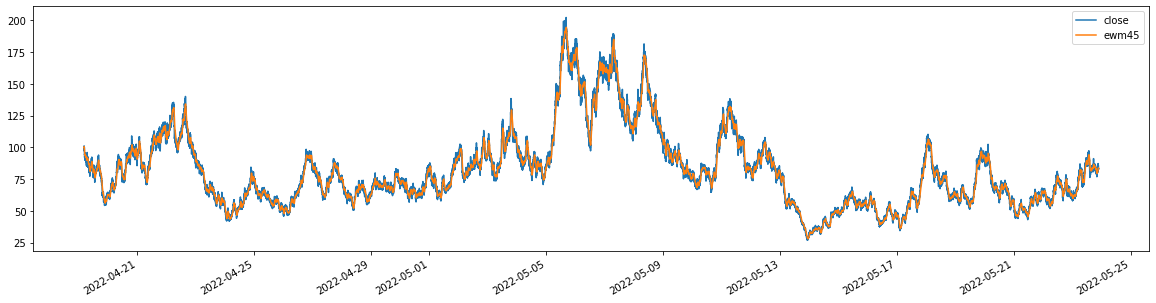

In [3]:
plt.rcParams["figure.figsize"] = (20, 5)

data = u.create_price_data(theta=0.0001, start_price=100, n_samples=50000)
data["ewm45"] = data["close"].ewm(span=45).mean()
data["close"].plot.line()
data["ewm45"].plot.line()
plt.legend()

# Finding Events and Barriers

In [4]:
ewm45 = data["ewm45"]
curr = data["close"]
prev = data["close"].shift(1)
cross_up = (curr > ewm45) & (prev < ewm45)
cross_down = (curr < ewm45) & (prev > ewm45)
data["dir"] = (
    cross_up * c.Dir.B + cross_down * c.Dir.S + (~(cross_up | cross_down)) * c.Dir.U
)
data["trade"] = cross_up | cross_down
data.head()

,close,ewm45,dir,trade
2022-04-19 04:26:00.245198,100.00,100.000000,0,False
2022-04-19 04:27:00.245198,100.11,100.056222,1,True
2022-04-19 04:28:00.245198,100.49,100.207288,1,True
2022-04-19 04:29:00.245198,101.08,100.440222,0,False
2022-04-19 04:30:00.245198,99.77,100.294004,-1,True


In [5]:
resampled = data.resample("H")
target = np.mean((resampled["close"].last() / resampled["close"].first()).std())
price_target = 1
stop_loss = 1
vertical_barrier = np.timedelta64(1, "h")

In [6]:
indices = data.loc[data["trade"]].index
barriers = signals.get_price_target_stop_loss_indices(
    data,
    indices,
    target=target,
    side=data.loc[indices, "dir"],
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)
barriers = signals.add_profit_target_stop_loss_outcome(barriers)
barriers.head()

,pt_dt,sl_dt,side,vb,pt_sl,pt
2022-04-19 04:27:00.245198,NaT,2022-04-19 04:51:00.245198,1,0 days 01:00:00,-1,False
2022-04-19 04:28:00.245198,NaT,2022-04-19 04:51:00.245198,1,0 days 01:00:00,-1,False
2022-04-19 04:30:00.245198,2022-04-19 04:52:00.245198,NaT,-1,0 days 01:00:00,1,True
2022-04-19 04:39:00.245198,NaT,2022-04-19 04:52:00.245198,1,0 days 01:00:00,-1,False
2022-04-19 04:40:00.245198,2022-04-19 05:04:00.245198,NaT,-1,0 days 01:00:00,1,True


# Concurrent Labels

In [18]:
counts = labels.get_concurrent_label_count(data, barriers)
counts.name = "counts"
counts.head()

2022-04-19 04:26:00.245198    0
2022-04-19 04:27:00.245198    1
2022-04-19 04:28:00.245198    2
2022-04-19 04:29:00.245198    2
2022-04-19 04:30:00.245198    3
Freq: T, Name: counts, dtype: int64

In [34]:
span = 45
ewmstd = np.sqrt((data["close"] / data["close"].shift(1)).ewm(span=span).var())
ewmstd.name = "tick_sd"
ewmstd

2022-04-19 04:26:00.245198         NaN
2022-04-19 04:27:00.245198         NaN
2022-04-19 04:28:00.245198    0.001906
2022-04-19 04:29:00.245198    0.002387
2022-04-19 04:30:00.245198    0.008708
                                ...   
2022-05-23 21:41:00.245198    0.008777
2022-05-23 21:42:00.245198    0.008595
2022-05-23 21:43:00.245198    0.008463
2022-05-23 21:44:00.245198    0.008344
2022-05-23 21:45:00.245198    0.008162
Freq: T, Name: tick_sd, Length: 50000, dtype: float64

<AxesSubplot:>

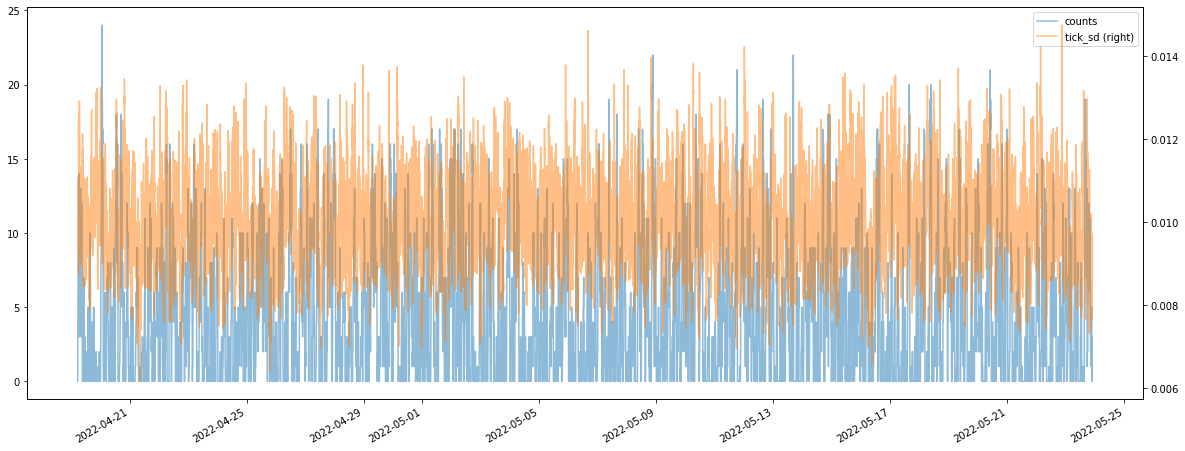

In [37]:
df = pd.concat([counts, ewmstd], axis=1).dropna()
df.iloc[span:].plot(secondary_y="tick_sd", figsize=(20, 8), alpha=0.5)

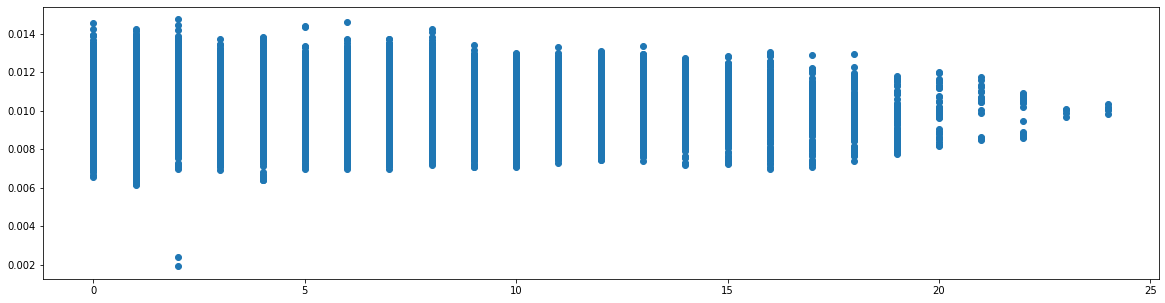

In [39]:
plt.scatter(counts, ewmstd)